In [2]:
# https://deeplearningcourses.com/c/deep-learning-recurrent-neural-networks-in-python
# https://udemy.com/deep-learning-recurrent-neural-networks-in-python
%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [10]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

def all_parity_pairs(nbit):
    # total number of samples (Ntotal) will be a multiple of 100
    # why did I make it this way? I don't remember.
    N = 2**nbit
    remainder = 100 - (N % 100)
    Ntotal = N + remainder
    X = np.zeros((Ntotal, nbit))
    Y = np.zeros(Ntotal)
    for ii in range(Ntotal):
        i = ii % N
        # now generate the ith sample
        for j in range(nbit):
            if i % (2**(j+1)) != 0:
                i -= 2**j
                X[ii,j] = 1
        Y[ii] = X[ii].sum() % 2
    return X, Y

In [4]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W = init_weight(M1, M2)
        b = np.zeros(M2)
        self.W = theano.shared(W, 'W_%s' % self.id)
        self.b = theano.shared(b, 'b_%s' % self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return T.nnet.relu(X.dot(self.W) + self.b)

In [15]:
class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=10e-3, mu=0.99, reg=10e-12, eps=10e-10, epochs=400, batch_sz=20, print_period=1, show_fig=False):

        # X = X.astype(np.float32)
        Y = Y.astype(np.int32)

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W = init_weight(M1, K)
        b = np.zeros(K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # for momentum
        dparams = [theano.shared(np.zeros(p.get_value().shape)) for p in self.params]

        # for rmsprop
        cache = [theano.shared(np.zeros(p.get_value().shape)) for p in self.params]

        # set up theano functions and variables
        thX = T.matrix('X')
        thY = T.ivector('Y')
        pY = self.forward(thX)

        rcost = reg*T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(thY.shape[0]), thY])) + rcost
        prediction = self.predict(thX)
        grads = T.grad(cost, self.params)

        # momentum only
        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            updates=updates,
        )

        n_batches = N / batch_sz
        # print "N:", N, "batch_sz:", batch_sz
        # print "n_batches:", n_batches
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(int(n_batches)):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                c, p = train_op(Xbatch, Ybatch)

                if j % print_period == 0:
                    costs.append(c)
                    e = np.mean(Ybatch != p)
                    print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)

    def predict(self, X):
        pY = self.forward(X)
        return T.argmax(pY, axis=1)

In [16]:
def wide():
    X, Y = all_parity_pairs(12)
    model = ANN([2048])
    model.fit(X, Y, learning_rate=10e-5, print_period=10, epochs=300, show_fig=True)

def deep():
    # Challenge - find a deeper, slimmer network to solve the problem
    X, Y = all_parity_pairs(12)
    model = ANN([1024]*2)
    model.fit(X, Y, learning_rate=10e-4, print_period=10, epochs=100, show_fig=True)

i: 0 j: 0 nb: 205.0 cost: 0.6960615941982541 error rate: 0.6
i: 0 j: 10 nb: 205.0 cost: 0.6929522102050452 error rate: 0.55
i: 0 j: 20 nb: 205.0 cost: 0.6937061842355047 error rate: 0.5
i: 0 j: 30 nb: 205.0 cost: 0.6920391738648277 error rate: 0.45
i: 0 j: 40 nb: 205.0 cost: 0.6940500551120264 error rate: 0.45
i: 0 j: 50 nb: 205.0 cost: 0.6849497810194131 error rate: 0.35
i: 0 j: 60 nb: 205.0 cost: 0.6958745799261236 error rate: 0.5
i: 0 j: 70 nb: 205.0 cost: 0.6972076012687449 error rate: 0.45
i: 0 j: 80 nb: 205.0 cost: 0.7051908820758509 error rate: 0.6
i: 0 j: 90 nb: 205.0 cost: 0.6893240125404362 error rate: 0.45
i: 0 j: 100 nb: 205.0 cost: 0.6940386875283445 error rate: 0.6
i: 0 j: 110 nb: 205.0 cost: 0.6992970761348678 error rate: 0.6
i: 0 j: 120 nb: 205.0 cost: 0.6970135811532262 error rate: 0.7
i: 0 j: 130 nb: 205.0 cost: 0.6918848842710402 error rate: 0.45
i: 0 j: 140 nb: 205.0 cost: 0.6978436910386322 error rate: 0.65
i: 0 j: 150 nb: 205.0 cost: 0.7000585856833331 error rate:

i: 7 j: 30 nb: 205.0 cost: 0.6950966737354064 error rate: 0.6
i: 7 j: 40 nb: 205.0 cost: 0.6945351535592312 error rate: 0.6
i: 7 j: 50 nb: 205.0 cost: 0.695734940466133 error rate: 0.55
i: 7 j: 60 nb: 205.0 cost: 0.6925193426663692 error rate: 0.4
i: 7 j: 70 nb: 205.0 cost: 0.6911755044240677 error rate: 0.35
i: 7 j: 80 nb: 205.0 cost: 0.6935071090308607 error rate: 0.55
i: 7 j: 90 nb: 205.0 cost: 0.6924088854746551 error rate: 0.55
i: 7 j: 100 nb: 205.0 cost: 0.6934297108546047 error rate: 0.5
i: 7 j: 110 nb: 205.0 cost: 0.6932955437106326 error rate: 0.5
i: 7 j: 120 nb: 205.0 cost: 0.6905454923665357 error rate: 0.35
i: 7 j: 130 nb: 205.0 cost: 0.6953416821808687 error rate: 0.65
i: 7 j: 140 nb: 205.0 cost: 0.6922635459673915 error rate: 0.5
i: 7 j: 150 nb: 205.0 cost: 0.6970560605013757 error rate: 0.55
i: 7 j: 160 nb: 205.0 cost: 0.6950311328065163 error rate: 0.6
i: 7 j: 170 nb: 205.0 cost: 0.6912725245879896 error rate: 0.45
i: 7 j: 180 nb: 205.0 cost: 0.6932400201180506 error ra

i: 14 j: 10 nb: 205.0 cost: 0.6953282408565575 error rate: 0.65
i: 14 j: 20 nb: 205.0 cost: 0.6937223843867011 error rate: 0.5
i: 14 j: 30 nb: 205.0 cost: 0.6921388022534504 error rate: 0.35
i: 14 j: 40 nb: 205.0 cost: 0.6910550627964871 error rate: 0.55
i: 14 j: 50 nb: 205.0 cost: 0.6924117000828676 error rate: 0.6
i: 14 j: 60 nb: 205.0 cost: 0.6919311948776217 error rate: 0.35
i: 14 j: 70 nb: 205.0 cost: 0.6952036678731174 error rate: 0.65
i: 14 j: 80 nb: 205.0 cost: 0.6926030389606096 error rate: 0.5
i: 14 j: 90 nb: 205.0 cost: 0.690512682590645 error rate: 0.25
i: 14 j: 100 nb: 205.0 cost: 0.6952342329956837 error rate: 0.65
i: 14 j: 110 nb: 205.0 cost: 0.6937915977551106 error rate: 0.6
i: 14 j: 120 nb: 205.0 cost: 0.6922894946748779 error rate: 0.5
i: 14 j: 130 nb: 205.0 cost: 0.6924959419339716 error rate: 0.45
i: 14 j: 140 nb: 205.0 cost: 0.6928409690935359 error rate: 0.5
i: 14 j: 150 nb: 205.0 cost: 0.6914095332486451 error rate: 0.4
i: 14 j: 160 nb: 205.0 cost: 0.69620232213

i: 21 j: 30 nb: 205.0 cost: 0.6862422201801949 error rate: 0.35
i: 21 j: 40 nb: 205.0 cost: 0.691896205896209 error rate: 0.45
i: 21 j: 50 nb: 205.0 cost: 0.6903054576920145 error rate: 0.45
i: 21 j: 60 nb: 205.0 cost: 0.6965135816998178 error rate: 0.65
i: 21 j: 70 nb: 205.0 cost: 0.7028747751507276 error rate: 0.75
i: 21 j: 80 nb: 205.0 cost: 0.6957648924867208 error rate: 0.55
i: 21 j: 90 nb: 205.0 cost: 0.6950003539844127 error rate: 0.55
i: 21 j: 100 nb: 205.0 cost: 0.6917402563104907 error rate: 0.5
i: 21 j: 110 nb: 205.0 cost: 0.6917452445379526 error rate: 0.35
i: 21 j: 120 nb: 205.0 cost: 0.6916056578738772 error rate: 0.35
i: 21 j: 130 nb: 205.0 cost: 0.695255953204795 error rate: 0.65
i: 21 j: 140 nb: 205.0 cost: 0.6939411819153304 error rate: 0.4
i: 21 j: 150 nb: 205.0 cost: 0.6913634845542057 error rate: 0.4
i: 21 j: 160 nb: 205.0 cost: 0.6941062421735087 error rate: 0.6
i: 21 j: 170 nb: 205.0 cost: 0.6928612855818975 error rate: 0.35
i: 21 j: 180 nb: 205.0 cost: 0.6912375

i: 27 j: 190 nb: 205.0 cost: 0.6921898419833863 error rate: 0.45
i: 27 j: 200 nb: 205.0 cost: 0.6913866813207064 error rate: 0.35
i: 28 j: 0 nb: 205.0 cost: 0.692243945843956 error rate: 0.4
i: 28 j: 10 nb: 205.0 cost: 0.6923084125200909 error rate: 0.55
i: 28 j: 20 nb: 205.0 cost: 0.6907736757156085 error rate: 0.35
i: 28 j: 30 nb: 205.0 cost: 0.6904139878461164 error rate: 0.3
i: 28 j: 40 nb: 205.0 cost: 0.6927301650051522 error rate: 0.55
i: 28 j: 50 nb: 205.0 cost: 0.6909479396703248 error rate: 0.35
i: 28 j: 60 nb: 205.0 cost: 0.6926898766913816 error rate: 0.45
i: 28 j: 70 nb: 205.0 cost: 0.6891166536839289 error rate: 0.35
i: 28 j: 80 nb: 205.0 cost: 0.6899787633007485 error rate: 0.45
i: 28 j: 90 nb: 205.0 cost: 0.690493027932447 error rate: 0.3
i: 28 j: 100 nb: 205.0 cost: 0.690518893840984 error rate: 0.35
i: 28 j: 110 nb: 205.0 cost: 0.6939304872912135 error rate: 0.55
i: 28 j: 120 nb: 205.0 cost: 0.6918620473274164 error rate: 0.4
i: 28 j: 130 nb: 205.0 cost: 0.691737034425

i: 34 j: 140 nb: 205.0 cost: 0.6939504952078113 error rate: 0.55
i: 34 j: 150 nb: 205.0 cost: 0.6934024296926214 error rate: 0.6
i: 34 j: 160 nb: 205.0 cost: 0.6882100883195595 error rate: 0.35
i: 34 j: 170 nb: 205.0 cost: 0.6960202680182529 error rate: 0.7
i: 34 j: 180 nb: 205.0 cost: 0.6921174244036704 error rate: 0.55
i: 34 j: 190 nb: 205.0 cost: 0.6883988259781868 error rate: 0.35
i: 34 j: 200 nb: 205.0 cost: 0.6899941790550217 error rate: 0.4
i: 35 j: 0 nb: 205.0 cost: 0.6904142714464132 error rate: 0.4
i: 35 j: 10 nb: 205.0 cost: 0.6914647224751992 error rate: 0.5
i: 35 j: 20 nb: 205.0 cost: 0.6924395195396188 error rate: 0.4
i: 35 j: 30 nb: 205.0 cost: 0.688603024343781 error rate: 0.45
i: 35 j: 40 nb: 205.0 cost: 0.6929100165547012 error rate: 0.55
i: 35 j: 50 nb: 205.0 cost: 0.6974553691519271 error rate: 0.65
i: 35 j: 60 nb: 205.0 cost: 0.6939933057980991 error rate: 0.55
i: 35 j: 70 nb: 205.0 cost: 0.6834999070559284 error rate: 0.35
i: 35 j: 80 nb: 205.0 cost: 0.70114462831

i: 41 j: 60 nb: 205.0 cost: 0.6842090424170285 error rate: 0.3
i: 41 j: 70 nb: 205.0 cost: 0.6917489675829767 error rate: 0.5
i: 41 j: 80 nb: 205.0 cost: 0.6901287962737371 error rate: 0.5
i: 41 j: 90 nb: 205.0 cost: 0.6860984575996495 error rate: 0.45
i: 41 j: 100 nb: 205.0 cost: 0.695640523672163 error rate: 0.6
i: 41 j: 110 nb: 205.0 cost: 0.6976704900086028 error rate: 0.6
i: 41 j: 120 nb: 205.0 cost: 0.6975332154515037 error rate: 0.65
i: 41 j: 130 nb: 205.0 cost: 0.6881360693637704 error rate: 0.45
i: 41 j: 140 nb: 205.0 cost: 0.6915191675812125 error rate: 0.55
i: 41 j: 150 nb: 205.0 cost: 0.6922040616958991 error rate: 0.65
i: 41 j: 160 nb: 205.0 cost: 0.6882591385344203 error rate: 0.25
i: 41 j: 170 nb: 205.0 cost: 0.6851965658462469 error rate: 0.2
i: 41 j: 180 nb: 205.0 cost: 0.6902096107140802 error rate: 0.3
i: 41 j: 190 nb: 205.0 cost: 0.6850690396125989 error rate: 0.1
i: 41 j: 200 nb: 205.0 cost: 0.6886959948542336 error rate: 0.15
i: 42 j: 0 nb: 205.0 cost: 0.691282485

i: 48 j: 30 nb: 205.0 cost: 0.6877769771161293 error rate: 0.3
i: 48 j: 40 nb: 205.0 cost: 0.683687475692363 error rate: 0.05
i: 48 j: 50 nb: 205.0 cost: 0.687426667198036 error rate: 0.25
i: 48 j: 60 nb: 205.0 cost: 0.6862743219860826 error rate: 0.3
i: 48 j: 70 nb: 205.0 cost: 0.6877999439820881 error rate: 0.3
i: 48 j: 80 nb: 205.0 cost: 0.688917090680468 error rate: 0.4
i: 48 j: 90 nb: 205.0 cost: 0.6838657735273529 error rate: 0.45
i: 48 j: 100 nb: 205.0 cost: 0.6862663434867015 error rate: 0.45
i: 48 j: 110 nb: 205.0 cost: 0.6897675433398682 error rate: 0.5
i: 48 j: 120 nb: 205.0 cost: 0.687853118060882 error rate: 0.5
i: 48 j: 130 nb: 205.0 cost: 0.6850235503656081 error rate: 0.45
i: 48 j: 140 nb: 205.0 cost: 0.691783776894621 error rate: 0.55
i: 48 j: 150 nb: 205.0 cost: 0.6913569152712947 error rate: 0.5
i: 48 j: 160 nb: 205.0 cost: 0.6896298471964335 error rate: 0.5
i: 48 j: 170 nb: 205.0 cost: 0.6905539501545217 error rate: 0.55
i: 48 j: 180 nb: 205.0 cost: 0.68472083984224

i: 54 j: 160 nb: 205.0 cost: 0.6859015816994269 error rate: 0.3
i: 54 j: 170 nb: 205.0 cost: 0.6853544926907372 error rate: 0.25
i: 54 j: 180 nb: 205.0 cost: 0.6842052755428372 error rate: 0.3
i: 54 j: 190 nb: 205.0 cost: 0.6837868203446863 error rate: 0.25
i: 54 j: 200 nb: 205.0 cost: 0.6899085987994564 error rate: 0.35
i: 55 j: 0 nb: 205.0 cost: 0.6865224082389242 error rate: 0.3
i: 55 j: 10 nb: 205.0 cost: 0.6854617756681163 error rate: 0.3
i: 55 j: 20 nb: 205.0 cost: 0.6831835585824765 error rate: 0.3
i: 55 j: 30 nb: 205.0 cost: 0.6893852141068596 error rate: 0.45
i: 55 j: 40 nb: 205.0 cost: 0.6863753663820629 error rate: 0.5
i: 55 j: 50 nb: 205.0 cost: 0.6945336948702048 error rate: 0.65
i: 55 j: 60 nb: 205.0 cost: 0.6850738569290654 error rate: 0.5
i: 55 j: 70 nb: 205.0 cost: 0.6827251998359484 error rate: 0.45
i: 55 j: 80 nb: 205.0 cost: 0.6888577645916958 error rate: 0.55
i: 55 j: 90 nb: 205.0 cost: 0.6812148384196784 error rate: 0.45
i: 55 j: 100 nb: 205.0 cost: 0.680504789293

i: 61 j: 60 nb: 205.0 cost: 0.6846863820995083 error rate: 0.3
i: 61 j: 70 nb: 205.0 cost: 0.6855586154193355 error rate: 0.4
i: 61 j: 80 nb: 205.0 cost: 0.679498733366234 error rate: 0.15
i: 61 j: 90 nb: 205.0 cost: 0.6834903396952212 error rate: 0.35
i: 61 j: 100 nb: 205.0 cost: 0.6867099676332096 error rate: 0.45
i: 61 j: 110 nb: 205.0 cost: 0.6791772633311934 error rate: 0.25
i: 61 j: 120 nb: 205.0 cost: 0.6805783448296993 error rate: 0.4
i: 61 j: 130 nb: 205.0 cost: 0.6876301867801168 error rate: 0.45
i: 61 j: 140 nb: 205.0 cost: 0.6859137402218595 error rate: 0.35
i: 61 j: 150 nb: 205.0 cost: 0.68322133668686 error rate: 0.3
i: 61 j: 160 nb: 205.0 cost: 0.6894179385680302 error rate: 0.45
i: 61 j: 170 nb: 205.0 cost: 0.6899912514262018 error rate: 0.5
i: 61 j: 180 nb: 205.0 cost: 0.6869460071657586 error rate: 0.3
i: 61 j: 190 nb: 205.0 cost: 0.6843788959812499 error rate: 0.35
i: 61 j: 200 nb: 205.0 cost: 0.6859336187381849 error rate: 0.2
i: 62 j: 0 nb: 205.0 cost: 0.6885140777

i: 68 j: 100 nb: 205.0 cost: 0.6867914698973532 error rate: 0.3
i: 68 j: 110 nb: 205.0 cost: 0.6772803391105029 error rate: 0.15
i: 68 j: 120 nb: 205.0 cost: 0.6764494049689715 error rate: 0.1
i: 68 j: 130 nb: 205.0 cost: 0.6807520596032817 error rate: 0.25
i: 68 j: 140 nb: 205.0 cost: 0.6785350764521831 error rate: 0.3
i: 68 j: 150 nb: 205.0 cost: 0.6812395757649939 error rate: 0.15
i: 68 j: 160 nb: 205.0 cost: 0.6806818904285283 error rate: 0.15
i: 68 j: 170 nb: 205.0 cost: 0.6808219178000645 error rate: 0.4
i: 68 j: 180 nb: 205.0 cost: 0.6889187980300169 error rate: 0.45
i: 68 j: 190 nb: 205.0 cost: 0.6809017558451232 error rate: 0.3
i: 68 j: 200 nb: 205.0 cost: 0.6743548461844802 error rate: 0.1
i: 69 j: 0 nb: 205.0 cost: 0.6789795694956966 error rate: 0.25
i: 69 j: 10 nb: 205.0 cost: 0.6769702982762962 error rate: 0.2
i: 69 j: 20 nb: 205.0 cost: 0.6818380043820649 error rate: 0.2
i: 69 j: 30 nb: 205.0 cost: 0.6747370210804492 error rate: 0.1
i: 69 j: 40 nb: 205.0 cost: 0.678724649

i: 75 j: 150 nb: 205.0 cost: 0.6795816390285352 error rate: 0.35
i: 75 j: 160 nb: 205.0 cost: 0.6819191168207664 error rate: 0.35
i: 75 j: 170 nb: 205.0 cost: 0.6709732839363777 error rate: 0.25
i: 75 j: 180 nb: 205.0 cost: 0.6735362779032426 error rate: 0.2
i: 75 j: 190 nb: 205.0 cost: 0.6764883994683604 error rate: 0.15
i: 75 j: 200 nb: 205.0 cost: 0.6792476113493796 error rate: 0.25
i: 76 j: 0 nb: 205.0 cost: 0.6747039993619712 error rate: 0.2
i: 76 j: 10 nb: 205.0 cost: 0.6809742263894627 error rate: 0.4
i: 76 j: 20 nb: 205.0 cost: 0.6761435881700608 error rate: 0.15
i: 76 j: 30 nb: 205.0 cost: 0.6744676266656173 error rate: 0.2
i: 76 j: 40 nb: 205.0 cost: 0.6683960052603338 error rate: 0.15
i: 76 j: 50 nb: 205.0 cost: 0.680658963104909 error rate: 0.25
i: 76 j: 60 nb: 205.0 cost: 0.6752432172892336 error rate: 0.3
i: 76 j: 70 nb: 205.0 cost: 0.675759470537741 error rate: 0.3
i: 76 j: 80 nb: 205.0 cost: 0.6663110076958163 error rate: 0.15
i: 76 j: 90 nb: 205.0 cost: 0.6624266432126

i: 82 j: 160 nb: 205.0 cost: 0.679051534114992 error rate: 0.3
i: 82 j: 170 nb: 205.0 cost: 0.6625002877165754 error rate: 0.1
i: 82 j: 180 nb: 205.0 cost: 0.6784117444347709 error rate: 0.25
i: 82 j: 190 nb: 205.0 cost: 0.6830253054111755 error rate: 0.25
i: 82 j: 200 nb: 205.0 cost: 0.669931772491703 error rate: 0.2
i: 83 j: 0 nb: 205.0 cost: 0.6583118931445798 error rate: 0.05
i: 83 j: 10 nb: 205.0 cost: 0.6680272880476291 error rate: 0.15
i: 83 j: 20 nb: 205.0 cost: 0.6737910127176218 error rate: 0.3
i: 83 j: 30 nb: 205.0 cost: 0.67265829006543 error rate: 0.3
i: 83 j: 40 nb: 205.0 cost: 0.674187303344488 error rate: 0.15
i: 83 j: 50 nb: 205.0 cost: 0.668281543942091 error rate: 0.15
i: 83 j: 60 nb: 205.0 cost: 0.6695651524545475 error rate: 0.3
i: 83 j: 70 nb: 205.0 cost: 0.6728766248190949 error rate: 0.4
i: 83 j: 80 nb: 205.0 cost: 0.6652952904724034 error rate: 0.35
i: 83 j: 90 nb: 205.0 cost: 0.6669651559168761 error rate: 0.3
i: 83 j: 100 nb: 205.0 cost: 0.6799595630482279 er

i: 89 j: 40 nb: 205.0 cost: 0.6706411987181026 error rate: 0.25
i: 89 j: 50 nb: 205.0 cost: 0.6613020166334046 error rate: 0.15
i: 89 j: 60 nb: 205.0 cost: 0.6549746836802217 error rate: 0.1
i: 89 j: 70 nb: 205.0 cost: 0.662296072992691 error rate: 0.2
i: 89 j: 80 nb: 205.0 cost: 0.6630822187788182 error rate: 0.2
i: 89 j: 90 nb: 205.0 cost: 0.6840553258797072 error rate: 0.35
i: 89 j: 100 nb: 205.0 cost: 0.6539361215550126 error rate: 0.25
i: 89 j: 110 nb: 205.0 cost: 0.6604841255204852 error rate: 0.15
i: 89 j: 120 nb: 205.0 cost: 0.6592624713099258 error rate: 0.15
i: 89 j: 130 nb: 205.0 cost: 0.6665660626769612 error rate: 0.15
i: 89 j: 140 nb: 205.0 cost: 0.6604677519507821 error rate: 0.2
i: 89 j: 150 nb: 205.0 cost: 0.6666605413564802 error rate: 0.25
i: 89 j: 160 nb: 205.0 cost: 0.6764623784110022 error rate: 0.3
i: 89 j: 170 nb: 205.0 cost: 0.6527440359562456 error rate: 0.15
i: 89 j: 180 nb: 205.0 cost: 0.6809538885131304 error rate: 0.35
i: 89 j: 190 nb: 205.0 cost: 0.670036

i: 96 j: 40 nb: 205.0 cost: 0.6528368263726989 error rate: 0.25
i: 96 j: 50 nb: 205.0 cost: 0.6574781030985619 error rate: 0.15
i: 96 j: 60 nb: 205.0 cost: 0.6641852745922052 error rate: 0.3
i: 96 j: 70 nb: 205.0 cost: 0.6582283419911427 error rate: 0.25
i: 96 j: 80 nb: 205.0 cost: 0.6688102064343898 error rate: 0.3
i: 96 j: 90 nb: 205.0 cost: 0.6305841546037396 error rate: 0.05
i: 96 j: 100 nb: 205.0 cost: 0.6495522849615041 error rate: 0.2
i: 96 j: 110 nb: 205.0 cost: 0.6579955459558311 error rate: 0.15
i: 96 j: 120 nb: 205.0 cost: 0.6731381109434986 error rate: 0.35
i: 96 j: 130 nb: 205.0 cost: 0.6441063086729377 error rate: 0.2
i: 96 j: 140 nb: 205.0 cost: 0.6759894275097711 error rate: 0.35
i: 96 j: 150 nb: 205.0 cost: 0.6563054870091346 error rate: 0.1
i: 96 j: 160 nb: 205.0 cost: 0.6526048248419144 error rate: 0.1
i: 96 j: 170 nb: 205.0 cost: 0.6438331759011916 error rate: 0.2
i: 96 j: 180 nb: 205.0 cost: 0.6420742803152818 error rate: 0.05
i: 96 j: 190 nb: 205.0 cost: 0.6410684

i: 103 j: 70 nb: 205.0 cost: 0.6244971347204907 error rate: 0.15
i: 103 j: 80 nb: 205.0 cost: 0.629300555728382 error rate: 0.15
i: 103 j: 90 nb: 205.0 cost: 0.6312028330476865 error rate: 0.15
i: 103 j: 100 nb: 205.0 cost: 0.6137750461834653 error rate: 0.0
i: 103 j: 110 nb: 205.0 cost: 0.5942169340399847 error rate: 0.05
i: 103 j: 120 nb: 205.0 cost: 0.6428933306136876 error rate: 0.2
i: 103 j: 130 nb: 205.0 cost: 0.6344980149260511 error rate: 0.2
i: 103 j: 140 nb: 205.0 cost: 0.613334885897717 error rate: 0.1
i: 103 j: 150 nb: 205.0 cost: 0.6456632455235833 error rate: 0.25
i: 103 j: 160 nb: 205.0 cost: 0.6575232683401747 error rate: 0.35
i: 103 j: 170 nb: 205.0 cost: 0.6372035484750642 error rate: 0.1
i: 103 j: 180 nb: 205.0 cost: 0.6386890030724773 error rate: 0.25
i: 103 j: 190 nb: 205.0 cost: 0.6448229809613792 error rate: 0.2
i: 103 j: 200 nb: 205.0 cost: 0.632432508910765 error rate: 0.15
i: 104 j: 0 nb: 205.0 cost: 0.6244019579832343 error rate: 0.1
i: 104 j: 10 nb: 205.0 co

i: 109 j: 170 nb: 205.0 cost: 0.6760822467581755 error rate: 0.3
i: 109 j: 180 nb: 205.0 cost: 0.6472836888384732 error rate: 0.3
i: 109 j: 190 nb: 205.0 cost: 0.6341299292791412 error rate: 0.2
i: 109 j: 200 nb: 205.0 cost: 0.635138565736932 error rate: 0.2
i: 110 j: 0 nb: 205.0 cost: 0.6471447607820046 error rate: 0.1
i: 110 j: 10 nb: 205.0 cost: 0.6271054653394613 error rate: 0.25
i: 110 j: 20 nb: 205.0 cost: 0.6212096667253469 error rate: 0.15
i: 110 j: 30 nb: 205.0 cost: 0.6084416120002176 error rate: 0.1
i: 110 j: 40 nb: 205.0 cost: 0.6467215210828553 error rate: 0.35
i: 110 j: 50 nb: 205.0 cost: 0.617507697216738 error rate: 0.05
i: 110 j: 60 nb: 205.0 cost: 0.6579495433963227 error rate: 0.35
i: 110 j: 70 nb: 205.0 cost: 0.6190238578121992 error rate: 0.2
i: 110 j: 80 nb: 205.0 cost: 0.614732197486585 error rate: 0.15
i: 110 j: 90 nb: 205.0 cost: 0.6413560986900634 error rate: 0.25
i: 110 j: 100 nb: 205.0 cost: 0.632759962607858 error rate: 0.2
i: 110 j: 110 nb: 205.0 cost: 0.6

i: 116 j: 30 nb: 205.0 cost: 0.6007774116569127 error rate: 0.2
i: 116 j: 40 nb: 205.0 cost: 0.6021630148030173 error rate: 0.15
i: 116 j: 50 nb: 205.0 cost: 0.6163866866898144 error rate: 0.2
i: 116 j: 60 nb: 205.0 cost: 0.5958882140679289 error rate: 0.15
i: 116 j: 70 nb: 205.0 cost: 0.5886256050111214 error rate: 0.1
i: 116 j: 80 nb: 205.0 cost: 0.6242714138734429 error rate: 0.3
i: 116 j: 90 nb: 205.0 cost: 0.6055900324409978 error rate: 0.15
i: 116 j: 100 nb: 205.0 cost: 0.6053795103588466 error rate: 0.3
i: 116 j: 110 nb: 205.0 cost: 0.5911709313255492 error rate: 0.15
i: 116 j: 120 nb: 205.0 cost: 0.5914463291278361 error rate: 0.15
i: 116 j: 130 nb: 205.0 cost: 0.65042724677695 error rate: 0.35
i: 116 j: 140 nb: 205.0 cost: 0.6577543803378072 error rate: 0.35
i: 116 j: 150 nb: 205.0 cost: 0.6308087610541669 error rate: 0.15
i: 116 j: 160 nb: 205.0 cost: 0.6317035754038078 error rate: 0.2
i: 116 j: 170 nb: 205.0 cost: 0.6301728804626202 error rate: 0.15
i: 116 j: 180 nb: 205.0 c

i: 122 j: 140 nb: 205.0 cost: 0.5884224896689672 error rate: 0.05
i: 122 j: 150 nb: 205.0 cost: 0.5777824938826902 error rate: 0.1
i: 122 j: 160 nb: 205.0 cost: 0.5470074727887441 error rate: 0.05
i: 122 j: 170 nb: 205.0 cost: 0.572743590922829 error rate: 0.05
i: 122 j: 180 nb: 205.0 cost: 0.5658352246259782 error rate: 0.1
i: 122 j: 190 nb: 205.0 cost: 0.6234845387363114 error rate: 0.2
i: 122 j: 200 nb: 205.0 cost: 0.6029482055930733 error rate: 0.1
i: 123 j: 0 nb: 205.0 cost: 0.5941668887631584 error rate: 0.25
i: 123 j: 10 nb: 205.0 cost: 0.603402431028448 error rate: 0.2
i: 123 j: 20 nb: 205.0 cost: 0.6078668800017738 error rate: 0.25
i: 123 j: 30 nb: 205.0 cost: 0.5717118263480373 error rate: 0.15
i: 123 j: 40 nb: 205.0 cost: 0.6411300794318188 error rate: 0.35
i: 123 j: 50 nb: 205.0 cost: 0.6067876384729458 error rate: 0.35
i: 123 j: 60 nb: 205.0 cost: 0.5740968974488139 error rate: 0.15
i: 123 j: 70 nb: 205.0 cost: 0.6037775134135188 error rate: 0.15
i: 123 j: 80 nb: 205.0 cos

i: 129 j: 50 nb: 205.0 cost: 0.5968926982456351 error rate: 0.05
i: 129 j: 60 nb: 205.0 cost: 0.5672140271744347 error rate: 0.1
i: 129 j: 70 nb: 205.0 cost: 0.6002912317342832 error rate: 0.2
i: 129 j: 80 nb: 205.0 cost: 0.5618914134873393 error rate: 0.05
i: 129 j: 90 nb: 205.0 cost: 0.5212503970478827 error rate: 0.05
i: 129 j: 100 nb: 205.0 cost: 0.6010230747302774 error rate: 0.2
i: 129 j: 110 nb: 205.0 cost: 0.554677264862007 error rate: 0.1
i: 129 j: 120 nb: 205.0 cost: 0.5645469743327924 error rate: 0.1
i: 129 j: 130 nb: 205.0 cost: 0.5779701345855327 error rate: 0.1
i: 129 j: 140 nb: 205.0 cost: 0.5931868228777069 error rate: 0.15
i: 129 j: 150 nb: 205.0 cost: 0.5667509315926018 error rate: 0.05
i: 129 j: 160 nb: 205.0 cost: 0.5594578957784864 error rate: 0.1
i: 129 j: 170 nb: 205.0 cost: 0.6269019682643998 error rate: 0.2
i: 129 j: 180 nb: 205.0 cost: 0.5684543484441017 error rate: 0.15
i: 129 j: 190 nb: 205.0 cost: 0.5334124657531718 error rate: 0.1
i: 129 j: 200 nb: 205.0 c

i: 135 j: 170 nb: 205.0 cost: 0.6048578293621113 error rate: 0.2
i: 135 j: 180 nb: 205.0 cost: 0.558425908583932 error rate: 0.1
i: 135 j: 190 nb: 205.0 cost: 0.5644339735940069 error rate: 0.25
i: 135 j: 200 nb: 205.0 cost: 0.5802820971622644 error rate: 0.15
i: 136 j: 0 nb: 205.0 cost: 0.5565418865709196 error rate: 0.2
i: 136 j: 10 nb: 205.0 cost: 0.5298113930577149 error rate: 0.1
i: 136 j: 20 nb: 205.0 cost: 0.5485568275164577 error rate: 0.1
i: 136 j: 30 nb: 205.0 cost: 0.5593876164677618 error rate: 0.2
i: 136 j: 40 nb: 205.0 cost: 0.5372890389125686 error rate: 0.15
i: 136 j: 50 nb: 205.0 cost: 0.4974828904918859 error rate: 0.05
i: 136 j: 60 nb: 205.0 cost: 0.5658153872930992 error rate: 0.1
i: 136 j: 70 nb: 205.0 cost: 0.6393194864500715 error rate: 0.45
i: 136 j: 80 nb: 205.0 cost: 0.5955536078337959 error rate: 0.3
i: 136 j: 90 nb: 205.0 cost: 0.5683669334987901 error rate: 0.1
i: 136 j: 100 nb: 205.0 cost: 0.5782436617241861 error rate: 0.25
i: 136 j: 110 nb: 205.0 cost: 0

i: 142 j: 80 nb: 205.0 cost: 0.5514830737406178 error rate: 0.2
i: 142 j: 90 nb: 205.0 cost: 0.5131825744703401 error rate: 0.15
i: 142 j: 100 nb: 205.0 cost: 0.5387182647485419 error rate: 0.2
i: 142 j: 110 nb: 205.0 cost: 0.5721372894752317 error rate: 0.2
i: 142 j: 120 nb: 205.0 cost: 0.5596041356214089 error rate: 0.25
i: 142 j: 130 nb: 205.0 cost: 0.5394815297316219 error rate: 0.05
i: 142 j: 140 nb: 205.0 cost: 0.6317581707318501 error rate: 0.35
i: 142 j: 150 nb: 205.0 cost: 0.5469210304918192 error rate: 0.15
i: 142 j: 160 nb: 205.0 cost: 0.5850907638149271 error rate: 0.25
i: 142 j: 170 nb: 205.0 cost: 0.5387391710048836 error rate: 0.2
i: 142 j: 180 nb: 205.0 cost: 0.550619184937183 error rate: 0.2
i: 142 j: 190 nb: 205.0 cost: 0.5332643807399999 error rate: 0.1
i: 142 j: 200 nb: 205.0 cost: 0.5465379056250402 error rate: 0.15
i: 143 j: 0 nb: 205.0 cost: 0.5116426200341209 error rate: 0.0
i: 143 j: 10 nb: 205.0 cost: 0.4736850081365394 error rate: 0.15
i: 143 j: 20 nb: 205.0 

i: 148 j: 180 nb: 205.0 cost: 0.49048963537259793 error rate: 0.05
i: 148 j: 190 nb: 205.0 cost: 0.4845039050570106 error rate: 0.2
i: 148 j: 200 nb: 205.0 cost: 0.47249002716345634 error rate: 0.15
i: 149 j: 0 nb: 205.0 cost: 0.4597159152487185 error rate: 0.15
i: 149 j: 10 nb: 205.0 cost: 0.4873978247308328 error rate: 0.1
i: 149 j: 20 nb: 205.0 cost: 0.4284918740160205 error rate: 0.1
i: 149 j: 30 nb: 205.0 cost: 0.5217680834096052 error rate: 0.1
i: 149 j: 40 nb: 205.0 cost: 0.4656763998327938 error rate: 0.1
i: 149 j: 50 nb: 205.0 cost: 0.5266422947406576 error rate: 0.15
i: 149 j: 60 nb: 205.0 cost: 0.521944855594557 error rate: 0.1
i: 149 j: 70 nb: 205.0 cost: 0.5424364232241248 error rate: 0.15
i: 149 j: 80 nb: 205.0 cost: 0.5165268835529487 error rate: 0.2
i: 149 j: 90 nb: 205.0 cost: 0.5095185459203015 error rate: 0.1
i: 149 j: 100 nb: 205.0 cost: 0.47166607657312204 error rate: 0.05
i: 149 j: 110 nb: 205.0 cost: 0.5849541465941949 error rate: 0.35
i: 149 j: 120 nb: 205.0 cos

i: 155 j: 80 nb: 205.0 cost: 0.4959936870361342 error rate: 0.1
i: 155 j: 90 nb: 205.0 cost: 0.4394423163357219 error rate: 0.1
i: 155 j: 100 nb: 205.0 cost: 0.5665255351825718 error rate: 0.3
i: 155 j: 110 nb: 205.0 cost: 0.5438202109622214 error rate: 0.2
i: 155 j: 120 nb: 205.0 cost: 0.47552850359098997 error rate: 0.05
i: 155 j: 130 nb: 205.0 cost: 0.4638239521601287 error rate: 0.1
i: 155 j: 140 nb: 205.0 cost: 0.5056499356441256 error rate: 0.1
i: 155 j: 150 nb: 205.0 cost: 0.49039358426860596 error rate: 0.05
i: 155 j: 160 nb: 205.0 cost: 0.4111935415831239 error rate: 0.0
i: 155 j: 170 nb: 205.0 cost: 0.47817191151514743 error rate: 0.1
i: 155 j: 180 nb: 205.0 cost: 0.4427779530225327 error rate: 0.0
i: 155 j: 190 nb: 205.0 cost: 0.5029296022528621 error rate: 0.25
i: 155 j: 200 nb: 205.0 cost: 0.42767066365453504 error rate: 0.05
i: 156 j: 0 nb: 205.0 cost: 0.4575899797591788 error rate: 0.05
i: 156 j: 10 nb: 205.0 cost: 0.4833651346589777 error rate: 0.15
i: 156 j: 20 nb: 205

i: 161 j: 160 nb: 205.0 cost: 0.4724292965578153 error rate: 0.1
i: 161 j: 170 nb: 205.0 cost: 0.4253670442529708 error rate: 0.1
i: 161 j: 180 nb: 205.0 cost: 0.48200079978199023 error rate: 0.2
i: 161 j: 190 nb: 205.0 cost: 0.48227530084011494 error rate: 0.1
i: 161 j: 200 nb: 205.0 cost: 0.3969740998588761 error rate: 0.05
i: 162 j: 0 nb: 205.0 cost: 0.5053249824555021 error rate: 0.1
i: 162 j: 10 nb: 205.0 cost: 0.368725473615315 error rate: 0.0
i: 162 j: 20 nb: 205.0 cost: 0.4564728703124478 error rate: 0.05
i: 162 j: 30 nb: 205.0 cost: 0.4757669872297325 error rate: 0.05
i: 162 j: 40 nb: 205.0 cost: 0.45646497915844536 error rate: 0.15
i: 162 j: 50 nb: 205.0 cost: 0.4270216841942471 error rate: 0.05
i: 162 j: 60 nb: 205.0 cost: 0.5205153369640886 error rate: 0.05
i: 162 j: 70 nb: 205.0 cost: 0.4232898252187135 error rate: 0.05
i: 162 j: 80 nb: 205.0 cost: 0.4325803238939724 error rate: 0.05
i: 162 j: 90 nb: 205.0 cost: 0.47964446039840436 error rate: 0.1
i: 162 j: 100 nb: 205.0 c

i: 167 j: 180 nb: 205.0 cost: 0.4157630290911548 error rate: 0.05
i: 167 j: 190 nb: 205.0 cost: 0.4384258859072742 error rate: 0.1
i: 167 j: 200 nb: 205.0 cost: 0.43610350413065485 error rate: 0.05
i: 168 j: 0 nb: 205.0 cost: 0.469352153384646 error rate: 0.2
i: 168 j: 10 nb: 205.0 cost: 0.4215304909637549 error rate: 0.05
i: 168 j: 20 nb: 205.0 cost: 0.42242730518348404 error rate: 0.0
i: 168 j: 30 nb: 205.0 cost: 0.4259193669715439 error rate: 0.05
i: 168 j: 40 nb: 205.0 cost: 0.43978141906011325 error rate: 0.05
i: 168 j: 50 nb: 205.0 cost: 0.4287242083997071 error rate: 0.0
i: 168 j: 60 nb: 205.0 cost: 0.48997743900818663 error rate: 0.15
i: 168 j: 70 nb: 205.0 cost: 0.46827148039551825 error rate: 0.25
i: 168 j: 80 nb: 205.0 cost: 0.4050906701584868 error rate: 0.0
i: 168 j: 90 nb: 205.0 cost: 0.37699704223073277 error rate: 0.05
i: 168 j: 100 nb: 205.0 cost: 0.44667433291128056 error rate: 0.1
i: 168 j: 110 nb: 205.0 cost: 0.4304769615103105 error rate: 0.1
i: 168 j: 120 nb: 205.

i: 174 j: 100 nb: 205.0 cost: 0.3739589459752995 error rate: 0.0
i: 174 j: 110 nb: 205.0 cost: 0.3583782976725089 error rate: 0.1
i: 174 j: 120 nb: 205.0 cost: 0.458233353364304 error rate: 0.2
i: 174 j: 130 nb: 205.0 cost: 0.3204586248502095 error rate: 0.0
i: 174 j: 140 nb: 205.0 cost: 0.3917761475042332 error rate: 0.05
i: 174 j: 150 nb: 205.0 cost: 0.3702462216422941 error rate: 0.05
i: 174 j: 160 nb: 205.0 cost: 0.4329700790668717 error rate: 0.1
i: 174 j: 170 nb: 205.0 cost: 0.392602174833519 error rate: 0.0
i: 174 j: 180 nb: 205.0 cost: 0.37848205170151106 error rate: 0.05
i: 174 j: 190 nb: 205.0 cost: 0.41135920546931853 error rate: 0.05
i: 174 j: 200 nb: 205.0 cost: 0.3271006256727787 error rate: 0.0
i: 175 j: 0 nb: 205.0 cost: 0.3137710236541583 error rate: 0.0
i: 175 j: 10 nb: 205.0 cost: 0.4580345295346596 error rate: 0.15
i: 175 j: 20 nb: 205.0 cost: 0.4260063296363387 error rate: 0.1
i: 175 j: 30 nb: 205.0 cost: 0.32188051469973794 error rate: 0.0
i: 175 j: 40 nb: 205.0 c

i: 180 j: 200 nb: 205.0 cost: 0.3205633803559512 error rate: 0.05
i: 181 j: 0 nb: 205.0 cost: 0.39584874383331725 error rate: 0.0
i: 181 j: 10 nb: 205.0 cost: 0.297959036868049 error rate: 0.0
i: 181 j: 20 nb: 205.0 cost: 0.3828069608087126 error rate: 0.15
i: 181 j: 30 nb: 205.0 cost: 0.3458817026745623 error rate: 0.05
i: 181 j: 40 nb: 205.0 cost: 0.40626332797476866 error rate: 0.1
i: 181 j: 50 nb: 205.0 cost: 0.31847303105661834 error rate: 0.05
i: 181 j: 60 nb: 205.0 cost: 0.33409124202755064 error rate: 0.0
i: 181 j: 70 nb: 205.0 cost: 0.39438893283252147 error rate: 0.15
i: 181 j: 80 nb: 205.0 cost: 0.355359963989909 error rate: 0.1
i: 181 j: 90 nb: 205.0 cost: 0.3603965508114624 error rate: 0.1
i: 181 j: 100 nb: 205.0 cost: 0.32132653349829854 error rate: 0.0
i: 181 j: 110 nb: 205.0 cost: 0.3523381696317193 error rate: 0.1
i: 181 j: 120 nb: 205.0 cost: 0.33616160083838514 error rate: 0.05
i: 181 j: 130 nb: 205.0 cost: 0.3739053749527204 error rate: 0.05
i: 181 j: 140 nb: 205.0 

i: 187 j: 90 nb: 205.0 cost: 0.34540468790467665 error rate: 0.05
i: 187 j: 100 nb: 205.0 cost: 0.38776131658919427 error rate: 0.05
i: 187 j: 110 nb: 205.0 cost: 0.4063940096122936 error rate: 0.1
i: 187 j: 120 nb: 205.0 cost: 0.33066915352522624 error rate: 0.0
i: 187 j: 130 nb: 205.0 cost: 0.330355593740468 error rate: 0.05
i: 187 j: 140 nb: 205.0 cost: 0.37766224294449247 error rate: 0.05
i: 187 j: 150 nb: 205.0 cost: 0.3148214311360885 error rate: 0.05
i: 187 j: 160 nb: 205.0 cost: 0.40573754899941983 error rate: 0.15
i: 187 j: 170 nb: 205.0 cost: 0.39000632100756333 error rate: 0.05
i: 187 j: 180 nb: 205.0 cost: 0.334701158678392 error rate: 0.0
i: 187 j: 190 nb: 205.0 cost: 0.30007899986754905 error rate: 0.0
i: 187 j: 200 nb: 205.0 cost: 0.29158519012086037 error rate: 0.05
i: 188 j: 0 nb: 205.0 cost: 0.3273864474928301 error rate: 0.0
i: 188 j: 10 nb: 205.0 cost: 0.36142385476563343 error rate: 0.0
i: 188 j: 20 nb: 205.0 cost: 0.35523480834500126 error rate: 0.05
i: 188 j: 30 

i: 193 j: 180 nb: 205.0 cost: 0.2421003426117183 error rate: 0.0
i: 193 j: 190 nb: 205.0 cost: 0.2800764867255312 error rate: 0.0
i: 193 j: 200 nb: 205.0 cost: 0.34728968291255025 error rate: 0.05
i: 194 j: 0 nb: 205.0 cost: 0.29181786246700253 error rate: 0.0
i: 194 j: 10 nb: 205.0 cost: 0.2700342180950632 error rate: 0.0
i: 194 j: 20 nb: 205.0 cost: 0.23074123992842457 error rate: 0.0
i: 194 j: 30 nb: 205.0 cost: 0.2799461804504655 error rate: 0.1
i: 194 j: 40 nb: 205.0 cost: 0.28604707152570935 error rate: 0.0
i: 194 j: 50 nb: 205.0 cost: 0.2892328203851284 error rate: 0.05
i: 194 j: 60 nb: 205.0 cost: 0.27946918853518754 error rate: 0.0
i: 194 j: 70 nb: 205.0 cost: 0.29657664435629594 error rate: 0.05
i: 194 j: 80 nb: 205.0 cost: 0.2898696660479992 error rate: 0.05
i: 194 j: 90 nb: 205.0 cost: 0.3586833968402879 error rate: 0.15
i: 194 j: 100 nb: 205.0 cost: 0.3093303048375136 error rate: 0.0
i: 194 j: 110 nb: 205.0 cost: 0.3672335314655351 error rate: 0.1
i: 194 j: 120 nb: 205.0 c

i: 200 j: 90 nb: 205.0 cost: 0.22725941902333582 error rate: 0.0
i: 200 j: 100 nb: 205.0 cost: 0.2819496738135152 error rate: 0.05
i: 200 j: 110 nb: 205.0 cost: 0.28288651198355885 error rate: 0.05
i: 200 j: 120 nb: 205.0 cost: 0.2613397432002295 error rate: 0.0
i: 200 j: 130 nb: 205.0 cost: 0.3287563866162866 error rate: 0.1
i: 200 j: 140 nb: 205.0 cost: 0.30174877895037716 error rate: 0.05
i: 200 j: 150 nb: 205.0 cost: 0.2863100538817213 error rate: 0.05
i: 200 j: 160 nb: 205.0 cost: 0.3021659071146443 error rate: 0.05
i: 200 j: 170 nb: 205.0 cost: 0.23512822670075595 error rate: 0.0
i: 200 j: 180 nb: 205.0 cost: 0.28746434827421086 error rate: 0.05
i: 200 j: 190 nb: 205.0 cost: 0.289217242815739 error rate: 0.05
i: 200 j: 200 nb: 205.0 cost: 0.2957643670190271 error rate: 0.0
i: 201 j: 0 nb: 205.0 cost: 0.3229098611078779 error rate: 0.0
i: 201 j: 10 nb: 205.0 cost: 0.2626248911661317 error rate: 0.0
i: 201 j: 20 nb: 205.0 cost: 0.25147616080062113 error rate: 0.0
i: 201 j: 30 nb: 2

i: 206 j: 180 nb: 205.0 cost: 0.24894191580005123 error rate: 0.0
i: 206 j: 190 nb: 205.0 cost: 0.27385727989492 error rate: 0.1
i: 206 j: 200 nb: 205.0 cost: 0.22840977266881465 error rate: 0.0
i: 207 j: 0 nb: 205.0 cost: 0.24117450498148668 error rate: 0.0
i: 207 j: 10 nb: 205.0 cost: 0.33722312007983657 error rate: 0.05
i: 207 j: 20 nb: 205.0 cost: 0.26629021020026544 error rate: 0.0
i: 207 j: 30 nb: 205.0 cost: 0.22355605066395162 error rate: 0.0
i: 207 j: 40 nb: 205.0 cost: 0.24064236423888793 error rate: 0.0
i: 207 j: 50 nb: 205.0 cost: 0.32564468180986805 error rate: 0.1
i: 207 j: 60 nb: 205.0 cost: 0.22586084620281324 error rate: 0.0
i: 207 j: 70 nb: 205.0 cost: 0.24058403362372255 error rate: 0.0
i: 207 j: 80 nb: 205.0 cost: 0.2898231136307123 error rate: 0.0
i: 207 j: 90 nb: 205.0 cost: 0.273909107175233 error rate: 0.0
i: 207 j: 100 nb: 205.0 cost: 0.2440696247801564 error rate: 0.0
i: 207 j: 110 nb: 205.0 cost: 0.24527357163263208 error rate: 0.0
i: 207 j: 120 nb: 205.0 cos

i: 213 j: 80 nb: 205.0 cost: 0.2202115306771181 error rate: 0.0
i: 213 j: 90 nb: 205.0 cost: 0.2828651912037155 error rate: 0.1
i: 213 j: 100 nb: 205.0 cost: 0.21726532998103892 error rate: 0.05
i: 213 j: 110 nb: 205.0 cost: 0.1856297414167724 error rate: 0.0
i: 213 j: 120 nb: 205.0 cost: 0.25799263640466796 error rate: 0.0
i: 213 j: 130 nb: 205.0 cost: 0.2721394550753949 error rate: 0.0
i: 213 j: 140 nb: 205.0 cost: 0.2416153558623337 error rate: 0.1
i: 213 j: 150 nb: 205.0 cost: 0.2374658256341659 error rate: 0.0
i: 213 j: 160 nb: 205.0 cost: 0.21406928223097424 error rate: 0.0
i: 213 j: 170 nb: 205.0 cost: 0.21575524671109822 error rate: 0.0
i: 213 j: 180 nb: 205.0 cost: 0.2800175446659379 error rate: 0.05
i: 213 j: 190 nb: 205.0 cost: 0.27773727644635376 error rate: 0.15
i: 213 j: 200 nb: 205.0 cost: 0.20110899497433846 error rate: 0.0
i: 214 j: 0 nb: 205.0 cost: 0.28952644777085057 error rate: 0.0
i: 214 j: 10 nb: 205.0 cost: 0.2510813068645317 error rate: 0.0
i: 214 j: 20 nb: 205

i: 219 j: 190 nb: 205.0 cost: 0.16551022054863054 error rate: 0.0
i: 219 j: 200 nb: 205.0 cost: 0.3223664627440793 error rate: 0.15
i: 220 j: 0 nb: 205.0 cost: 0.18202793299987902 error rate: 0.0
i: 220 j: 10 nb: 205.0 cost: 0.22018856849882343 error rate: 0.0
i: 220 j: 20 nb: 205.0 cost: 0.2058364469957133 error rate: 0.0
i: 220 j: 30 nb: 205.0 cost: 0.17557864409236482 error rate: 0.0
i: 220 j: 40 nb: 205.0 cost: 0.2596729444557428 error rate: 0.0
i: 220 j: 50 nb: 205.0 cost: 0.2223889888909058 error rate: 0.05
i: 220 j: 60 nb: 205.0 cost: 0.1830883759319171 error rate: 0.0
i: 220 j: 70 nb: 205.0 cost: 0.2932933934876999 error rate: 0.1
i: 220 j: 80 nb: 205.0 cost: 0.2236095720755828 error rate: 0.05
i: 220 j: 90 nb: 205.0 cost: 0.21551838042740554 error rate: 0.0
i: 220 j: 100 nb: 205.0 cost: 0.23773975142996934 error rate: 0.0
i: 220 j: 110 nb: 205.0 cost: 0.24789629496379395 error rate: 0.05
i: 220 j: 120 nb: 205.0 cost: 0.18618280374977741 error rate: 0.0
i: 220 j: 130 nb: 205.0 

i: 226 j: 90 nb: 205.0 cost: 0.1952214630990482 error rate: 0.05
i: 226 j: 100 nb: 205.0 cost: 0.1771464903180821 error rate: 0.0
i: 226 j: 110 nb: 205.0 cost: 0.2526699609028131 error rate: 0.05
i: 226 j: 120 nb: 205.0 cost: 0.15322538895274126 error rate: 0.0
i: 226 j: 130 nb: 205.0 cost: 0.168759908743886 error rate: 0.0
i: 226 j: 140 nb: 205.0 cost: 0.2439206778398791 error rate: 0.0
i: 226 j: 150 nb: 205.0 cost: 0.20069285051948643 error rate: 0.0
i: 226 j: 160 nb: 205.0 cost: 0.16658572710734157 error rate: 0.0
i: 226 j: 170 nb: 205.0 cost: 0.20961791106429828 error rate: 0.05
i: 226 j: 180 nb: 205.0 cost: 0.2347284361637544 error rate: 0.1
i: 226 j: 190 nb: 205.0 cost: 0.24890907372879942 error rate: 0.1
i: 226 j: 200 nb: 205.0 cost: 0.2383507731045886 error rate: 0.0
i: 227 j: 0 nb: 205.0 cost: 0.2165560813248688 error rate: 0.0
i: 227 j: 10 nb: 205.0 cost: 0.18792681259335864 error rate: 0.0
i: 227 j: 20 nb: 205.0 cost: 0.2613939960312697 error rate: 0.05
i: 227 j: 30 nb: 205.

i: 232 j: 200 nb: 205.0 cost: 0.24425437934375893 error rate: 0.05
i: 233 j: 0 nb: 205.0 cost: 0.1746157318605256 error rate: 0.05
i: 233 j: 10 nb: 205.0 cost: 0.18501297027943606 error rate: 0.05
i: 233 j: 20 nb: 205.0 cost: 0.144752196770994 error rate: 0.0
i: 233 j: 30 nb: 205.0 cost: 0.13472870207419393 error rate: 0.0
i: 233 j: 40 nb: 205.0 cost: 0.16673965976679958 error rate: 0.0
i: 233 j: 50 nb: 205.0 cost: 0.21830312570164698 error rate: 0.05
i: 233 j: 60 nb: 205.0 cost: 0.21675861789591772 error rate: 0.05
i: 233 j: 70 nb: 205.0 cost: 0.18415232847071034 error rate: 0.0
i: 233 j: 80 nb: 205.0 cost: 0.2121110925314245 error rate: 0.0
i: 233 j: 90 nb: 205.0 cost: 0.1917533084728776 error rate: 0.0
i: 233 j: 100 nb: 205.0 cost: 0.1451898814892706 error rate: 0.0
i: 233 j: 110 nb: 205.0 cost: 0.23143552367242395 error rate: 0.05
i: 233 j: 120 nb: 205.0 cost: 0.16129727012939035 error rate: 0.0
i: 233 j: 130 nb: 205.0 cost: 0.20008265734239786 error rate: 0.0
i: 233 j: 140 nb: 205

i: 239 j: 140 nb: 205.0 cost: 0.14910418333345987 error rate: 0.0
i: 239 j: 150 nb: 205.0 cost: 0.1698757920654758 error rate: 0.05
i: 239 j: 160 nb: 205.0 cost: 0.2068814413234139 error rate: 0.05
i: 239 j: 170 nb: 205.0 cost: 0.18558861854666328 error rate: 0.0
i: 239 j: 180 nb: 205.0 cost: 0.1345323699135055 error rate: 0.0
i: 239 j: 190 nb: 205.0 cost: 0.1860165965912654 error rate: 0.05
i: 239 j: 200 nb: 205.0 cost: 0.14512629650080072 error rate: 0.0
i: 240 j: 0 nb: 205.0 cost: 0.11338524844195332 error rate: 0.0
i: 240 j: 10 nb: 205.0 cost: 0.16974895596264258 error rate: 0.0
i: 240 j: 20 nb: 205.0 cost: 0.14861245141476384 error rate: 0.0
i: 240 j: 30 nb: 205.0 cost: 0.23309779122174346 error rate: 0.05
i: 240 j: 40 nb: 205.0 cost: 0.14431410446693096 error rate: 0.0
i: 240 j: 50 nb: 205.0 cost: 0.1317725355385739 error rate: 0.0
i: 240 j: 60 nb: 205.0 cost: 0.15792041212128557 error rate: 0.0
i: 240 j: 70 nb: 205.0 cost: 0.19138775364905908 error rate: 0.05
i: 240 j: 80 nb: 20

i: 246 j: 90 nb: 205.0 cost: 0.18317055185800526 error rate: 0.0
i: 246 j: 100 nb: 205.0 cost: 0.18276577829849727 error rate: 0.0
i: 246 j: 110 nb: 205.0 cost: 0.16732456789789266 error rate: 0.0
i: 246 j: 120 nb: 205.0 cost: 0.18330919431396359 error rate: 0.0
i: 246 j: 130 nb: 205.0 cost: 0.161751566503568 error rate: 0.0
i: 246 j: 140 nb: 205.0 cost: 0.17706367919283394 error rate: 0.0
i: 246 j: 150 nb: 205.0 cost: 0.12748849781617103 error rate: 0.0
i: 246 j: 160 nb: 205.0 cost: 0.1629210713285698 error rate: 0.0
i: 246 j: 170 nb: 205.0 cost: 0.18128628822523962 error rate: 0.0
i: 246 j: 180 nb: 205.0 cost: 0.15785129327751946 error rate: 0.0
i: 246 j: 190 nb: 205.0 cost: 0.19148368848466812 error rate: 0.05
i: 246 j: 200 nb: 205.0 cost: 0.13996382324277537 error rate: 0.0
i: 247 j: 0 nb: 205.0 cost: 0.12123978983242467 error rate: 0.0
i: 247 j: 10 nb: 205.0 cost: 0.14218541348019356 error rate: 0.0
i: 247 j: 20 nb: 205.0 cost: 0.10104075420575283 error rate: 0.0
i: 247 j: 30 nb: 

i: 252 j: 160 nb: 205.0 cost: 0.1384498657748491 error rate: 0.0
i: 252 j: 170 nb: 205.0 cost: 0.1737261541934931 error rate: 0.0
i: 252 j: 180 nb: 205.0 cost: 0.1686667837749267 error rate: 0.1
i: 252 j: 190 nb: 205.0 cost: 0.20037834331099294 error rate: 0.0
i: 252 j: 200 nb: 205.0 cost: 0.11278699036195815 error rate: 0.0
i: 253 j: 0 nb: 205.0 cost: 0.12917313039651163 error rate: 0.0
i: 253 j: 10 nb: 205.0 cost: 0.11019435568318307 error rate: 0.0
i: 253 j: 20 nb: 205.0 cost: 0.14186224378291218 error rate: 0.05
i: 253 j: 30 nb: 205.0 cost: 0.19090944180184635 error rate: 0.0
i: 253 j: 40 nb: 205.0 cost: 0.11000912550742101 error rate: 0.0
i: 253 j: 50 nb: 205.0 cost: 0.13910176155385973 error rate: 0.0
i: 253 j: 60 nb: 205.0 cost: 0.20932173585413646 error rate: 0.05
i: 253 j: 70 nb: 205.0 cost: 0.14834370337002398 error rate: 0.0
i: 253 j: 80 nb: 205.0 cost: 0.1451876720508162 error rate: 0.05
i: 253 j: 90 nb: 205.0 cost: 0.12164847418510291 error rate: 0.0
i: 253 j: 100 nb: 205.

i: 259 j: 70 nb: 205.0 cost: 0.11502022485293065 error rate: 0.0
i: 259 j: 80 nb: 205.0 cost: 0.1169063998611713 error rate: 0.0
i: 259 j: 90 nb: 205.0 cost: 0.19224181902833004 error rate: 0.0
i: 259 j: 100 nb: 205.0 cost: 0.13256092091398528 error rate: 0.0
i: 259 j: 110 nb: 205.0 cost: 0.20261074000167137 error rate: 0.1
i: 259 j: 120 nb: 205.0 cost: 0.1311537406975098 error rate: 0.0
i: 259 j: 130 nb: 205.0 cost: 0.1264664401195941 error rate: 0.0
i: 259 j: 140 nb: 205.0 cost: 0.1617127517519281 error rate: 0.0
i: 259 j: 150 nb: 205.0 cost: 0.12067856404689968 error rate: 0.0
i: 259 j: 160 nb: 205.0 cost: 0.1542448172635565 error rate: 0.0
i: 259 j: 170 nb: 205.0 cost: 0.12354173767427493 error rate: 0.0
i: 259 j: 180 nb: 205.0 cost: 0.20369093013984327 error rate: 0.05
i: 259 j: 190 nb: 205.0 cost: 0.1295384416666852 error rate: 0.0
i: 259 j: 200 nb: 205.0 cost: 0.185885328216182 error rate: 0.05
i: 260 j: 0 nb: 205.0 cost: 0.13776637110515283 error rate: 0.0
i: 260 j: 10 nb: 205.

i: 265 j: 140 nb: 205.0 cost: 0.07618869370315993 error rate: 0.0
i: 265 j: 150 nb: 205.0 cost: 0.09610832097238275 error rate: 0.0
i: 265 j: 160 nb: 205.0 cost: 0.11144848442115839 error rate: 0.0
i: 265 j: 170 nb: 205.0 cost: 0.10551324568819949 error rate: 0.0
i: 265 j: 180 nb: 205.0 cost: 0.09102900232427444 error rate: 0.0
i: 265 j: 190 nb: 205.0 cost: 0.14700341779260284 error rate: 0.1
i: 265 j: 200 nb: 205.0 cost: 0.08933060934855588 error rate: 0.0
i: 266 j: 0 nb: 205.0 cost: 0.11812644399089176 error rate: 0.0
i: 266 j: 10 nb: 205.0 cost: 0.15318051528577573 error rate: 0.0
i: 266 j: 20 nb: 205.0 cost: 0.1259064824984568 error rate: 0.0
i: 266 j: 30 nb: 205.0 cost: 0.15051188159047527 error rate: 0.0
i: 266 j: 40 nb: 205.0 cost: 0.1609002250345906 error rate: 0.05
i: 266 j: 50 nb: 205.0 cost: 0.10584643206116631 error rate: 0.0
i: 266 j: 60 nb: 205.0 cost: 0.1727107475513218 error rate: 0.0
i: 266 j: 70 nb: 205.0 cost: 0.10060123709821497 error rate: 0.0
i: 266 j: 80 nb: 205.

i: 272 j: 0 nb: 205.0 cost: 0.1429487105112038 error rate: 0.0
i: 272 j: 10 nb: 205.0 cost: 0.1423374598793879 error rate: 0.05
i: 272 j: 20 nb: 205.0 cost: 0.10355926536710922 error rate: 0.0
i: 272 j: 30 nb: 205.0 cost: 0.13869187265952854 error rate: 0.0
i: 272 j: 40 nb: 205.0 cost: 0.10199951843934826 error rate: 0.0
i: 272 j: 50 nb: 205.0 cost: 0.09390467619668728 error rate: 0.0
i: 272 j: 60 nb: 205.0 cost: 0.1135426263588848 error rate: 0.0
i: 272 j: 70 nb: 205.0 cost: 0.1608796607564955 error rate: 0.05
i: 272 j: 80 nb: 205.0 cost: 0.12587054146945395 error rate: 0.0
i: 272 j: 90 nb: 205.0 cost: 0.1754715798034317 error rate: 0.0
i: 272 j: 100 nb: 205.0 cost: 0.12087755668235316 error rate: 0.0
i: 272 j: 110 nb: 205.0 cost: 0.10400088206203334 error rate: 0.0
i: 272 j: 120 nb: 205.0 cost: 0.12026036924236919 error rate: 0.0
i: 272 j: 130 nb: 205.0 cost: 0.10268768122476543 error rate: 0.0
i: 272 j: 140 nb: 205.0 cost: 0.06760531723865244 error rate: 0.0
i: 272 j: 150 nb: 205.0 

i: 278 j: 90 nb: 205.0 cost: 0.06365073086710092 error rate: 0.0
i: 278 j: 100 nb: 205.0 cost: 0.06613801193409485 error rate: 0.0
i: 278 j: 110 nb: 205.0 cost: 0.12189942100423562 error rate: 0.0
i: 278 j: 120 nb: 205.0 cost: 0.06997880257426249 error rate: 0.0
i: 278 j: 130 nb: 205.0 cost: 0.09691362308209828 error rate: 0.0
i: 278 j: 140 nb: 205.0 cost: 0.14621092131068444 error rate: 0.05
i: 278 j: 150 nb: 205.0 cost: 0.13446587413425776 error rate: 0.0
i: 278 j: 160 nb: 205.0 cost: 0.11016886159781952 error rate: 0.0
i: 278 j: 170 nb: 205.0 cost: 0.1582461203310081 error rate: 0.0
i: 278 j: 180 nb: 205.0 cost: 0.1654156059597699 error rate: 0.05
i: 278 j: 190 nb: 205.0 cost: 0.1015973066947928 error rate: 0.0
i: 278 j: 200 nb: 205.0 cost: 0.07593971287985361 error rate: 0.0
i: 279 j: 0 nb: 205.0 cost: 0.1228123551409334 error rate: 0.0
i: 279 j: 10 nb: 205.0 cost: 0.10972305409593534 error rate: 0.0
i: 279 j: 20 nb: 205.0 cost: 0.09998581751872845 error rate: 0.0
i: 279 j: 30 nb: 

i: 284 j: 150 nb: 205.0 cost: 0.07254588864801993 error rate: 0.0
i: 284 j: 160 nb: 205.0 cost: 0.07600493909726863 error rate: 0.0
i: 284 j: 170 nb: 205.0 cost: 0.10935295658829455 error rate: 0.0
i: 284 j: 180 nb: 205.0 cost: 0.10563226841069143 error rate: 0.0
i: 284 j: 190 nb: 205.0 cost: 0.09159610240573812 error rate: 0.0
i: 284 j: 200 nb: 205.0 cost: 0.07623580297717594 error rate: 0.0
i: 285 j: 0 nb: 205.0 cost: 0.07242034708934272 error rate: 0.0
i: 285 j: 10 nb: 205.0 cost: 0.09574907254943116 error rate: 0.0
i: 285 j: 20 nb: 205.0 cost: 0.12587815486712398 error rate: 0.0
i: 285 j: 30 nb: 205.0 cost: 0.077269798460332 error rate: 0.0
i: 285 j: 40 nb: 205.0 cost: 0.1671757501616033 error rate: 0.05
i: 285 j: 50 nb: 205.0 cost: 0.08163458574734614 error rate: 0.0
i: 285 j: 60 nb: 205.0 cost: 0.07325864676863668 error rate: 0.0
i: 285 j: 70 nb: 205.0 cost: 0.08617227587681855 error rate: 0.0
i: 285 j: 80 nb: 205.0 cost: 0.1474680931479167 error rate: 0.0
i: 285 j: 90 nb: 205.0 

i: 291 j: 30 nb: 205.0 cost: 0.11251505054931797 error rate: 0.05
i: 291 j: 40 nb: 205.0 cost: 0.07644895895985901 error rate: 0.0
i: 291 j: 50 nb: 205.0 cost: 0.07099818917199309 error rate: 0.0
i: 291 j: 60 nb: 205.0 cost: 0.1830896433616767 error rate: 0.1
i: 291 j: 70 nb: 205.0 cost: 0.12901485608172483 error rate: 0.05
i: 291 j: 80 nb: 205.0 cost: 0.11073455765067908 error rate: 0.05
i: 291 j: 90 nb: 205.0 cost: 0.15269783576063192 error rate: 0.0
i: 291 j: 100 nb: 205.0 cost: 0.11215077354094453 error rate: 0.0
i: 291 j: 110 nb: 205.0 cost: 0.09708721150313024 error rate: 0.0
i: 291 j: 120 nb: 205.0 cost: 0.13569995578627683 error rate: 0.05
i: 291 j: 130 nb: 205.0 cost: 0.06988266444907087 error rate: 0.0
i: 291 j: 140 nb: 205.0 cost: 0.05761063654650498 error rate: 0.0
i: 291 j: 150 nb: 205.0 cost: 0.10633906870739006 error rate: 0.0
i: 291 j: 160 nb: 205.0 cost: 0.10402061533741574 error rate: 0.0
i: 291 j: 170 nb: 205.0 cost: 0.12962114372678138 error rate: 0.0
i: 291 j: 180 

i: 297 j: 120 nb: 205.0 cost: 0.06390258032829078 error rate: 0.0
i: 297 j: 130 nb: 205.0 cost: 0.13104062386610854 error rate: 0.0
i: 297 j: 140 nb: 205.0 cost: 0.10080770221495156 error rate: 0.0
i: 297 j: 150 nb: 205.0 cost: 0.11519967801191631 error rate: 0.0
i: 297 j: 160 nb: 205.0 cost: 0.07023359360864243 error rate: 0.0
i: 297 j: 170 nb: 205.0 cost: 0.08328407330990374 error rate: 0.0
i: 297 j: 180 nb: 205.0 cost: 0.07012957598779851 error rate: 0.0
i: 297 j: 190 nb: 205.0 cost: 0.09476449934529685 error rate: 0.0
i: 297 j: 200 nb: 205.0 cost: 0.08746122610334685 error rate: 0.0
i: 298 j: 0 nb: 205.0 cost: 0.0861528717670836 error rate: 0.0
i: 298 j: 10 nb: 205.0 cost: 0.12029998286664173 error rate: 0.0
i: 298 j: 20 nb: 205.0 cost: 0.09943359654080952 error rate: 0.05
i: 298 j: 30 nb: 205.0 cost: 0.12128662479679435 error rate: 0.0
i: 298 j: 40 nb: 205.0 cost: 0.12830469669281513 error rate: 0.0
i: 298 j: 50 nb: 205.0 cost: 0.06285575252104598 error rate: 0.0
i: 298 j: 60 nb: 

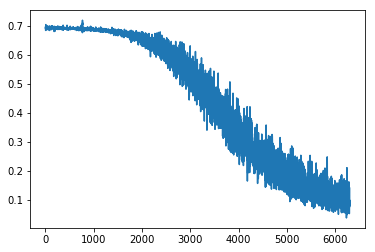

In [17]:
wide()

i: 0 j: 0 nb: 205.0 cost: 0.6910854652214975 error rate: 0.35
i: 0 j: 10 nb: 205.0 cost: 0.6935192771239043 error rate: 0.55
i: 0 j: 20 nb: 205.0 cost: 0.6869690468105658 error rate: 0.3
i: 0 j: 30 nb: 205.0 cost: 0.6875021965664713 error rate: 0.4
i: 0 j: 40 nb: 205.0 cost: 0.6938723803800978 error rate: 0.6
i: 0 j: 50 nb: 205.0 cost: 0.6939446725398442 error rate: 0.45
i: 0 j: 60 nb: 205.0 cost: 0.6931394442060802 error rate: 0.6
i: 0 j: 70 nb: 205.0 cost: 0.6856634659188551 error rate: 0.45
i: 0 j: 80 nb: 205.0 cost: 0.677963805475411 error rate: 0.3
i: 0 j: 90 nb: 205.0 cost: 0.6798828691475621 error rate: 0.35
i: 0 j: 100 nb: 205.0 cost: 0.6954397450425833 error rate: 0.5
i: 0 j: 110 nb: 205.0 cost: 0.7027182661938981 error rate: 0.55
i: 0 j: 120 nb: 205.0 cost: 0.6850354842015156 error rate: 0.4
i: 0 j: 130 nb: 205.0 cost: 0.6892064174491618 error rate: 0.4
i: 0 j: 140 nb: 205.0 cost: 0.6922274954190575 error rate: 0.5
i: 0 j: 150 nb: 205.0 cost: 0.6877419012967211 error rate: 0.

i: 6 j: 60 nb: 205.0 cost: 0.6963457993774703 error rate: 0.55
i: 6 j: 70 nb: 205.0 cost: 0.6944260698276227 error rate: 0.45
i: 6 j: 80 nb: 205.0 cost: 0.6932455700612999 error rate: 0.55
i: 6 j: 90 nb: 205.0 cost: 0.6931384668367779 error rate: 0.45
i: 6 j: 100 nb: 205.0 cost: 0.6924364424091127 error rate: 0.45
i: 6 j: 110 nb: 205.0 cost: 0.6913146223247028 error rate: 0.4
i: 6 j: 120 nb: 205.0 cost: 0.6968617328686822 error rate: 0.6
i: 6 j: 130 nb: 205.0 cost: 0.6937473062008237 error rate: 0.5
i: 6 j: 140 nb: 205.0 cost: 0.6987569383493948 error rate: 0.6
i: 6 j: 150 nb: 205.0 cost: 0.6830145328494245 error rate: 0.3
i: 6 j: 160 nb: 205.0 cost: 0.7014140701464274 error rate: 0.7
i: 6 j: 170 nb: 205.0 cost: 0.6895989961702979 error rate: 0.45
i: 6 j: 180 nb: 205.0 cost: 0.6937487508765161 error rate: 0.5
i: 6 j: 190 nb: 205.0 cost: 0.6893793049479848 error rate: 0.4
i: 6 j: 200 nb: 205.0 cost: 0.6917366077771787 error rate: 0.4
i: 7 j: 0 nb: 205.0 cost: 0.6999818212987616 error ra

i: 12 j: 100 nb: 205.0 cost: 0.6909506200749863 error rate: 0.4
i: 12 j: 110 nb: 205.0 cost: 0.6933991827479689 error rate: 0.55
i: 12 j: 120 nb: 205.0 cost: 0.6902986363117687 error rate: 0.45
i: 12 j: 130 nb: 205.0 cost: 0.6911492922025058 error rate: 0.45
i: 12 j: 140 nb: 205.0 cost: 0.6939862677475295 error rate: 0.6
i: 12 j: 150 nb: 205.0 cost: 0.6994393616899545 error rate: 0.65
i: 12 j: 160 nb: 205.0 cost: 0.6942912272516654 error rate: 0.55
i: 12 j: 170 nb: 205.0 cost: 0.6911847233588048 error rate: 0.5
i: 12 j: 180 nb: 205.0 cost: 0.6909299658247816 error rate: 0.25
i: 12 j: 190 nb: 205.0 cost: 0.6901892655031288 error rate: 0.4
i: 12 j: 200 nb: 205.0 cost: 0.6904802228966981 error rate: 0.5
i: 13 j: 0 nb: 205.0 cost: 0.6880294020195573 error rate: 0.4
i: 13 j: 10 nb: 205.0 cost: 0.6875265903225931 error rate: 0.4
i: 13 j: 20 nb: 205.0 cost: 0.694144844858431 error rate: 0.55
i: 13 j: 30 nb: 205.0 cost: 0.704621784946289 error rate: 0.7
i: 13 j: 40 nb: 205.0 cost: 0.6937340129

i: 18 j: 150 nb: 205.0 cost: 0.6879152464228847 error rate: 0.45
i: 18 j: 160 nb: 205.0 cost: 0.694524367601724 error rate: 0.5
i: 18 j: 170 nb: 205.0 cost: 0.7005049538725767 error rate: 0.55
i: 18 j: 180 nb: 205.0 cost: 0.7029304538524667 error rate: 0.65
i: 18 j: 190 nb: 205.0 cost: 0.6882279013254786 error rate: 0.45
i: 18 j: 200 nb: 205.0 cost: 0.666609342602708 error rate: 0.35
i: 19 j: 0 nb: 205.0 cost: 0.7190329275046838 error rate: 0.75
i: 19 j: 10 nb: 205.0 cost: 0.677245870508045 error rate: 0.45
i: 19 j: 20 nb: 205.0 cost: 0.7003604105897729 error rate: 0.55
i: 19 j: 30 nb: 205.0 cost: 0.6802099931997589 error rate: 0.5
i: 19 j: 40 nb: 205.0 cost: 0.6964995555157791 error rate: 0.55
i: 19 j: 50 nb: 205.0 cost: 0.6638377861773214 error rate: 0.3
i: 19 j: 60 nb: 205.0 cost: 0.6690888981404356 error rate: 0.3
i: 19 j: 70 nb: 205.0 cost: 0.7028793116765365 error rate: 0.75
i: 19 j: 80 nb: 205.0 cost: 0.6807353330339755 error rate: 0.4
i: 19 j: 90 nb: 205.0 cost: 0.6942751922428

i: 24 j: 190 nb: 205.0 cost: 0.6984072462096199 error rate: 0.5
i: 24 j: 200 nb: 205.0 cost: 0.7846183321738663 error rate: 0.55
i: 25 j: 0 nb: 205.0 cost: 0.5487434127258572 error rate: 0.25
i: 25 j: 10 nb: 205.0 cost: 0.6746542948414448 error rate: 0.45
i: 25 j: 20 nb: 205.0 cost: 0.6468231403297009 error rate: 0.35
i: 25 j: 30 nb: 205.0 cost: 0.6803896007052409 error rate: 0.4
i: 25 j: 40 nb: 205.0 cost: 0.7211797205849484 error rate: 0.55
i: 25 j: 50 nb: 205.0 cost: 0.7847808654420076 error rate: 0.6
i: 25 j: 60 nb: 205.0 cost: 0.624433969222727 error rate: 0.35
i: 25 j: 70 nb: 205.0 cost: 0.685435030033907 error rate: 0.5
i: 25 j: 80 nb: 205.0 cost: 0.6510905727856977 error rate: 0.3
i: 25 j: 90 nb: 205.0 cost: 0.6216748769873288 error rate: 0.35
i: 25 j: 100 nb: 205.0 cost: 0.5942960678727826 error rate: 0.35
i: 25 j: 110 nb: 205.0 cost: 0.5575094698749257 error rate: 0.2
i: 25 j: 120 nb: 205.0 cost: 0.7871414882419521 error rate: 0.6
i: 25 j: 130 nb: 205.0 cost: 0.62371959782050

i: 31 j: 10 nb: 205.0 cost: 0.46056951142242414 error rate: 0.25
i: 31 j: 20 nb: 205.0 cost: 0.30775874371099116 error rate: 0.1
i: 31 j: 30 nb: 205.0 cost: 0.3214013773435329 error rate: 0.05
i: 31 j: 40 nb: 205.0 cost: 0.28484798575351566 error rate: 0.1
i: 31 j: 50 nb: 205.0 cost: 0.47604021455422735 error rate: 0.25
i: 31 j: 60 nb: 205.0 cost: 0.4840171341900328 error rate: 0.3
i: 31 j: 70 nb: 205.0 cost: 0.4363470468851713 error rate: 0.25
i: 31 j: 80 nb: 205.0 cost: 0.48584606709587186 error rate: 0.15
i: 31 j: 90 nb: 205.0 cost: 0.5103045140070617 error rate: 0.25
i: 31 j: 100 nb: 205.0 cost: 0.33323762171223 error rate: 0.05
i: 31 j: 110 nb: 205.0 cost: 0.32038748851796506 error rate: 0.15
i: 31 j: 120 nb: 205.0 cost: 0.4953088665496133 error rate: 0.15
i: 31 j: 130 nb: 205.0 cost: 0.3276114845585646 error rate: 0.15
i: 31 j: 140 nb: 205.0 cost: 0.3307095614351384 error rate: 0.1
i: 31 j: 150 nb: 205.0 cost: 0.338440880104213 error rate: 0.2
i: 31 j: 160 nb: 205.0 cost: 0.42936

i: 37 j: 40 nb: 205.0 cost: 0.10873688955705244 error rate: 0.05
i: 37 j: 50 nb: 205.0 cost: 0.017831270929049185 error rate: 0.0
i: 37 j: 60 nb: 205.0 cost: 0.04571135005956541 error rate: 0.0
i: 37 j: 70 nb: 205.0 cost: 0.06371052120227527 error rate: 0.0
i: 37 j: 80 nb: 205.0 cost: 0.056617153878022075 error rate: 0.0
i: 37 j: 90 nb: 205.0 cost: 0.06762558675815589 error rate: 0.05
i: 37 j: 100 nb: 205.0 cost: 0.474138157515129 error rate: 0.15
i: 37 j: 110 nb: 205.0 cost: 0.0954646873230559 error rate: 0.0
i: 37 j: 120 nb: 205.0 cost: 0.08020232808036347 error rate: 0.0
i: 37 j: 130 nb: 205.0 cost: 0.0981305236449748 error rate: 0.0
i: 37 j: 140 nb: 205.0 cost: 0.5840862909507695 error rate: 0.25
i: 37 j: 150 nb: 205.0 cost: 0.10995151640123929 error rate: 0.05
i: 37 j: 160 nb: 205.0 cost: 0.22897256543859817 error rate: 0.1
i: 37 j: 170 nb: 205.0 cost: 0.1129361735662114 error rate: 0.05
i: 37 j: 180 nb: 205.0 cost: 0.14710110769277118 error rate: 0.1
i: 37 j: 190 nb: 205.0 cost: 

i: 43 j: 60 nb: 205.0 cost: 0.02269838458267224 error rate: 0.0
i: 43 j: 70 nb: 205.0 cost: 0.06227198000304147 error rate: 0.05
i: 43 j: 80 nb: 205.0 cost: 0.026416137689711093 error rate: 0.0
i: 43 j: 90 nb: 205.0 cost: 0.1620304742085999 error rate: 0.05
i: 43 j: 100 nb: 205.0 cost: 0.02312917637778233 error rate: 0.0
i: 43 j: 110 nb: 205.0 cost: 0.05644151434684841 error rate: 0.0
i: 43 j: 120 nb: 205.0 cost: 0.06793145263314077 error rate: 0.05
i: 43 j: 130 nb: 205.0 cost: 0.04968476084790066 error rate: 0.05
i: 43 j: 140 nb: 205.0 cost: 0.03664660270280632 error rate: 0.0
i: 43 j: 150 nb: 205.0 cost: 0.0036912824828872577 error rate: 0.0
i: 43 j: 160 nb: 205.0 cost: 0.01607234518239426 error rate: 0.0
i: 43 j: 170 nb: 205.0 cost: 0.00799456168415543 error rate: 0.0
i: 43 j: 180 nb: 205.0 cost: 0.010766853410774399 error rate: 0.0
i: 43 j: 190 nb: 205.0 cost: 0.008258808040572498 error rate: 0.0
i: 43 j: 200 nb: 205.0 cost: 0.018354094877580555 error rate: 0.0
i: 44 j: 0 nb: 205.0

i: 49 j: 60 nb: 205.0 cost: 0.05209380374753632 error rate: 0.0
i: 49 j: 70 nb: 205.0 cost: 0.00921251233442047 error rate: 0.0
i: 49 j: 80 nb: 205.0 cost: 0.02383648912813558 error rate: 0.0
i: 49 j: 90 nb: 205.0 cost: 0.005642348053191286 error rate: 0.0
i: 49 j: 100 nb: 205.0 cost: 0.01286793609793771 error rate: 0.0
i: 49 j: 110 nb: 205.0 cost: 0.016513473216711583 error rate: 0.0
i: 49 j: 120 nb: 205.0 cost: 0.012763496194161728 error rate: 0.0
i: 49 j: 130 nb: 205.0 cost: 0.0011000281864175514 error rate: 0.0
i: 49 j: 140 nb: 205.0 cost: 0.012714187141445062 error rate: 0.0
i: 49 j: 150 nb: 205.0 cost: 0.001718461368999207 error rate: 0.0
i: 49 j: 160 nb: 205.0 cost: 0.06028455814852803 error rate: 0.05
i: 49 j: 170 nb: 205.0 cost: 0.0633489682538939 error rate: 0.05
i: 49 j: 180 nb: 205.0 cost: 0.05589632695191509 error rate: 0.0
i: 49 j: 190 nb: 205.0 cost: 0.0045727063983751004 error rate: 0.0
i: 49 j: 200 nb: 205.0 cost: 0.11530732535037455 error rate: 0.05
i: 50 j: 0 nb: 205

i: 55 j: 90 nb: 205.0 cost: 0.0005005968672258984 error rate: 0.0
i: 55 j: 100 nb: 205.0 cost: 0.0007596920026835916 error rate: 0.0
i: 55 j: 110 nb: 205.0 cost: 0.0031762427326738787 error rate: 0.0
i: 55 j: 120 nb: 205.0 cost: 0.006628757086041053 error rate: 0.0
i: 55 j: 130 nb: 205.0 cost: 0.004778400494349639 error rate: 0.0
i: 55 j: 140 nb: 205.0 cost: 0.0019025750326949217 error rate: 0.0
i: 55 j: 150 nb: 205.0 cost: 0.006263315816113556 error rate: 0.0
i: 55 j: 160 nb: 205.0 cost: 0.002566844412476369 error rate: 0.0
i: 55 j: 170 nb: 205.0 cost: 0.00756116301490741 error rate: 0.0
i: 55 j: 180 nb: 205.0 cost: 0.004258529403232474 error rate: 0.0
i: 55 j: 190 nb: 205.0 cost: 0.03907183911415748 error rate: 0.05
i: 55 j: 200 nb: 205.0 cost: 0.007266433396131448 error rate: 0.0
i: 56 j: 0 nb: 205.0 cost: 0.0012229047136130475 error rate: 0.0
i: 56 j: 10 nb: 205.0 cost: 0.002674405396307382 error rate: 0.0
i: 56 j: 20 nb: 205.0 cost: 0.1112255407117413 error rate: 0.05
i: 56 j: 30 

i: 61 j: 80 nb: 205.0 cost: 0.0009241787508994593 error rate: 0.0
i: 61 j: 90 nb: 205.0 cost: 0.001589817159498736 error rate: 0.0
i: 61 j: 100 nb: 205.0 cost: 0.0004043377004502509 error rate: 0.0
i: 61 j: 110 nb: 205.0 cost: 0.0017561634213143359 error rate: 0.0
i: 61 j: 120 nb: 205.0 cost: 0.0004151524920404269 error rate: 0.0
i: 61 j: 130 nb: 205.0 cost: 0.0016498443854083772 error rate: 0.0
i: 61 j: 140 nb: 205.0 cost: 0.00038429487020802644 error rate: 0.0
i: 61 j: 150 nb: 205.0 cost: 0.0006643165214904567 error rate: 0.0
i: 61 j: 160 nb: 205.0 cost: 0.0019350808891104073 error rate: 0.0
i: 61 j: 170 nb: 205.0 cost: 0.00010453344706833882 error rate: 0.0
i: 61 j: 180 nb: 205.0 cost: 0.000417192836955593 error rate: 0.0
i: 61 j: 190 nb: 205.0 cost: 0.0003445423449707771 error rate: 0.0
i: 61 j: 200 nb: 205.0 cost: 0.0018968622269724372 error rate: 0.0
i: 62 j: 0 nb: 205.0 cost: 0.00245953116692986 error rate: 0.0
i: 62 j: 10 nb: 205.0 cost: 0.00026396241323189555 error rate: 0.0
i

i: 67 j: 70 nb: 205.0 cost: 0.0010852935577801304 error rate: 0.0
i: 67 j: 80 nb: 205.0 cost: 0.00023395593791692245 error rate: 0.0
i: 67 j: 90 nb: 205.0 cost: 0.00035623226743738815 error rate: 0.0
i: 67 j: 100 nb: 205.0 cost: 0.0001664926291092153 error rate: 0.0
i: 67 j: 110 nb: 205.0 cost: 0.000711422673041281 error rate: 0.0
i: 67 j: 120 nb: 205.0 cost: 0.0002762675119907457 error rate: 0.0
i: 67 j: 130 nb: 205.0 cost: 0.0004755989172305837 error rate: 0.0
i: 67 j: 140 nb: 205.0 cost: 0.0007687243395135022 error rate: 0.0
i: 67 j: 150 nb: 205.0 cost: 0.0002741389353836439 error rate: 0.0
i: 67 j: 160 nb: 205.0 cost: 0.0008768719589526306 error rate: 0.0
i: 67 j: 170 nb: 205.0 cost: 0.0016227917192119861 error rate: 0.0
i: 67 j: 180 nb: 205.0 cost: 0.0004397834033123567 error rate: 0.0
i: 67 j: 190 nb: 205.0 cost: 0.003039316376082973 error rate: 0.0
i: 67 j: 200 nb: 205.0 cost: 0.0007960162362726306 error rate: 0.0
i: 68 j: 0 nb: 205.0 cost: 0.0004415299899245099 error rate: 0.0


i: 73 j: 70 nb: 205.0 cost: 0.00011085492801181653 error rate: 0.0
i: 73 j: 80 nb: 205.0 cost: 0.0001215132362704443 error rate: 0.0
i: 73 j: 90 nb: 205.0 cost: 0.00046287958529625794 error rate: 0.0
i: 73 j: 100 nb: 205.0 cost: 0.0001584952589669278 error rate: 0.0
i: 73 j: 110 nb: 205.0 cost: 0.00040596130278269907 error rate: 0.0
i: 73 j: 120 nb: 205.0 cost: 0.00036505170672243586 error rate: 0.0
i: 73 j: 130 nb: 205.0 cost: 0.001132738967491504 error rate: 0.0
i: 73 j: 140 nb: 205.0 cost: 0.0009816044118325354 error rate: 0.0
i: 73 j: 150 nb: 205.0 cost: 0.0007430757993051162 error rate: 0.0
i: 73 j: 160 nb: 205.0 cost: 0.00033002528579640484 error rate: 0.0
i: 73 j: 170 nb: 205.0 cost: 0.0006426786364500312 error rate: 0.0
i: 73 j: 180 nb: 205.0 cost: 0.0022718239240819456 error rate: 0.0
i: 73 j: 190 nb: 205.0 cost: 0.0024449506415493245 error rate: 0.0
i: 73 j: 200 nb: 205.0 cost: 0.0018251628026917782 error rate: 0.0
i: 74 j: 0 nb: 205.0 cost: 0.00013001370328646084 error rate:

i: 79 j: 50 nb: 205.0 cost: 0.00024020920656842753 error rate: 0.0
i: 79 j: 60 nb: 205.0 cost: 0.00029679545203729565 error rate: 0.0
i: 79 j: 70 nb: 205.0 cost: 0.00014490172563116 error rate: 0.0
i: 79 j: 80 nb: 205.0 cost: 0.0005464521362929628 error rate: 0.0
i: 79 j: 90 nb: 205.0 cost: 0.00015427082884571846 error rate: 0.0
i: 79 j: 100 nb: 205.0 cost: 0.001450999949244728 error rate: 0.0
i: 79 j: 110 nb: 205.0 cost: 0.00022197872428512638 error rate: 0.0
i: 79 j: 120 nb: 205.0 cost: 0.00018151693050204618 error rate: 0.0
i: 79 j: 130 nb: 205.0 cost: 0.00031237658241215426 error rate: 0.0
i: 79 j: 140 nb: 205.0 cost: 0.00038006568279003454 error rate: 0.0
i: 79 j: 150 nb: 205.0 cost: 0.0002525778157512277 error rate: 0.0
i: 79 j: 160 nb: 205.0 cost: 0.00035912785470435085 error rate: 0.0
i: 79 j: 170 nb: 205.0 cost: 0.00034070463231743306 error rate: 0.0
i: 79 j: 180 nb: 205.0 cost: 0.0004939960856879178 error rate: 0.0
i: 79 j: 190 nb: 205.0 cost: 0.0006387918876392787 error rate

i: 85 j: 20 nb: 205.0 cost: 0.0005622448330328017 error rate: 0.0
i: 85 j: 30 nb: 205.0 cost: 0.0001243338694571572 error rate: 0.0
i: 85 j: 40 nb: 205.0 cost: 0.0001894520413476745 error rate: 0.0
i: 85 j: 50 nb: 205.0 cost: 0.0006243382958894902 error rate: 0.0
i: 85 j: 60 nb: 205.0 cost: 0.0007628803119801981 error rate: 0.0
i: 85 j: 70 nb: 205.0 cost: 0.00015750294386732852 error rate: 0.0
i: 85 j: 80 nb: 205.0 cost: 0.00015933704176146916 error rate: 0.0
i: 85 j: 90 nb: 205.0 cost: 0.00036071613527446683 error rate: 0.0
i: 85 j: 100 nb: 205.0 cost: 0.00015393811027376576 error rate: 0.0
i: 85 j: 110 nb: 205.0 cost: 0.0004463837799492431 error rate: 0.0
i: 85 j: 120 nb: 205.0 cost: 0.0003245492666831574 error rate: 0.0
i: 85 j: 130 nb: 205.0 cost: 0.00010199311921783803 error rate: 0.0
i: 85 j: 140 nb: 205.0 cost: 0.00026904011998230264 error rate: 0.0
i: 85 j: 150 nb: 205.0 cost: 0.0005782524523204367 error rate: 0.0
i: 85 j: 160 nb: 205.0 cost: 0.0002799932801298522 error rate: 0

i: 90 j: 200 nb: 205.0 cost: 0.0009209610796101468 error rate: 0.0
i: 91 j: 0 nb: 205.0 cost: 0.00020535153756570624 error rate: 0.0
i: 91 j: 10 nb: 205.0 cost: 0.0007790317284469559 error rate: 0.0
i: 91 j: 20 nb: 205.0 cost: 0.000559564854633618 error rate: 0.0
i: 91 j: 30 nb: 205.0 cost: 0.0009132400921552277 error rate: 0.0
i: 91 j: 40 nb: 205.0 cost: 0.0001986734598228588 error rate: 0.0
i: 91 j: 50 nb: 205.0 cost: 0.0005077060416752926 error rate: 0.0
i: 91 j: 60 nb: 205.0 cost: 0.00011444988786283833 error rate: 0.0
i: 91 j: 70 nb: 205.0 cost: 0.0008879286871546263 error rate: 0.0
i: 91 j: 80 nb: 205.0 cost: 0.000976439941030676 error rate: 0.0
i: 91 j: 90 nb: 205.0 cost: 0.0003262302937933281 error rate: 0.0
i: 91 j: 100 nb: 205.0 cost: 0.00021865247768211078 error rate: 0.0
i: 91 j: 110 nb: 205.0 cost: 4.09891270549493e-05 error rate: 0.0
i: 91 j: 120 nb: 205.0 cost: 0.00017784820798573672 error rate: 0.0
i: 91 j: 130 nb: 205.0 cost: 7.672152884134576e-05 error rate: 0.0
i: 91

i: 96 j: 190 nb: 205.0 cost: 0.000251420481123329 error rate: 0.0
i: 96 j: 200 nb: 205.0 cost: 0.0002568800925249552 error rate: 0.0
i: 97 j: 0 nb: 205.0 cost: 0.00015376271052962832 error rate: 0.0
i: 97 j: 10 nb: 205.0 cost: 0.0005462990895833188 error rate: 0.0
i: 97 j: 20 nb: 205.0 cost: 0.00030973769126725576 error rate: 0.0
i: 97 j: 30 nb: 205.0 cost: 0.0007834438780089198 error rate: 0.0
i: 97 j: 40 nb: 205.0 cost: 0.0005723049486189616 error rate: 0.0
i: 97 j: 50 nb: 205.0 cost: 8.988479968002287e-05 error rate: 0.0
i: 97 j: 60 nb: 205.0 cost: 0.0005242190191832529 error rate: 0.0
i: 97 j: 70 nb: 205.0 cost: 0.0008019398500703144 error rate: 0.0
i: 97 j: 80 nb: 205.0 cost: 0.000464220103918792 error rate: 0.0
i: 97 j: 90 nb: 205.0 cost: 0.0007474617591069595 error rate: 0.0
i: 97 j: 100 nb: 205.0 cost: 0.00010191574872301865 error rate: 0.0
i: 97 j: 110 nb: 205.0 cost: 6.216567925199758e-05 error rate: 0.0
i: 97 j: 120 nb: 205.0 cost: 0.00014306573546369293 error rate: 0.0
i: 9

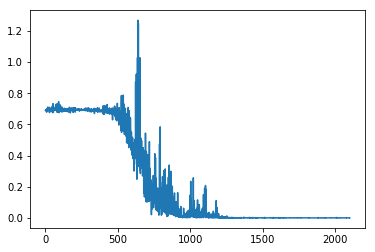

In [18]:
deep()